In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
from libutil import out_dir
from dotenv import load_dotenv; load_dotenv()
from importlib import reload; import libplot; 
from sklearn import metrics
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

In [52]:
datasets = [
    #"rcv1",
    "webkb",
    "spamassassin",
    "avila",
    "smartphone",
    "swarm",
    "sensorless",
    "splice",
    "anuran"
]

In [53]:
def read_stopping(name):
    file = f"{out_dir()}/stopping/{name}__none__uncertainty__svm-linear__dataset_size=1000__labelled_size=10__test_size=0.5__n_runs=10__ret_classifiers=True__ensure_y=True__stop_info=True__aggregate=False__stop_function=r__pool_subsample=1000.pickle"
    with open(file, "rb") as f:
        return dill.load(f)

In [54]:
# this is 10 runs on svm-linear, initial set size 10, no data modification
# None indicates a condition failed to stop
results = {}
for name in datasets:
    results[name] = read_stopping(name)

In [57]:
results['webkb']['GOAL'][20]

(320, 0.8514285714285714, 0.8514285714285714, 0.953301790661388)

`results` has the format:

    Dataset name ->

        Stopping condition name ->

            Array of 10 runs ->

                Four tuple of:

                    Number of instances labelled

                    Accuracy at stopping point

                    f1 score at stopping point

                    roc auc score at stopping point
                

If the condition did not stop on a particular run all values are `None`

In [20]:
to_plot = [
    #'uncertainty_min',
    'SC_entropy_mcs',
    #'SC_oracle_acc_mcs',
    #'SC_mes',
    'EVM',
    'stabilizing_predictions',
    'VM',
    'SSNCut',
    'GOAL',
    'SC_oracle_acc',
    'Stabilizing Predictions',
    'Performance Convergence',
    'Uncertainty Convergence',
    'Max Confidence',
    'Contradictory Information',
    'Classification Change',
    'Overall Uncertainty'
]
results_filter = {dataset: {name: results for name, results in conds.items() if name in to_plot} for dataset, conds in results.items()}

## Full Range Pareto Plots

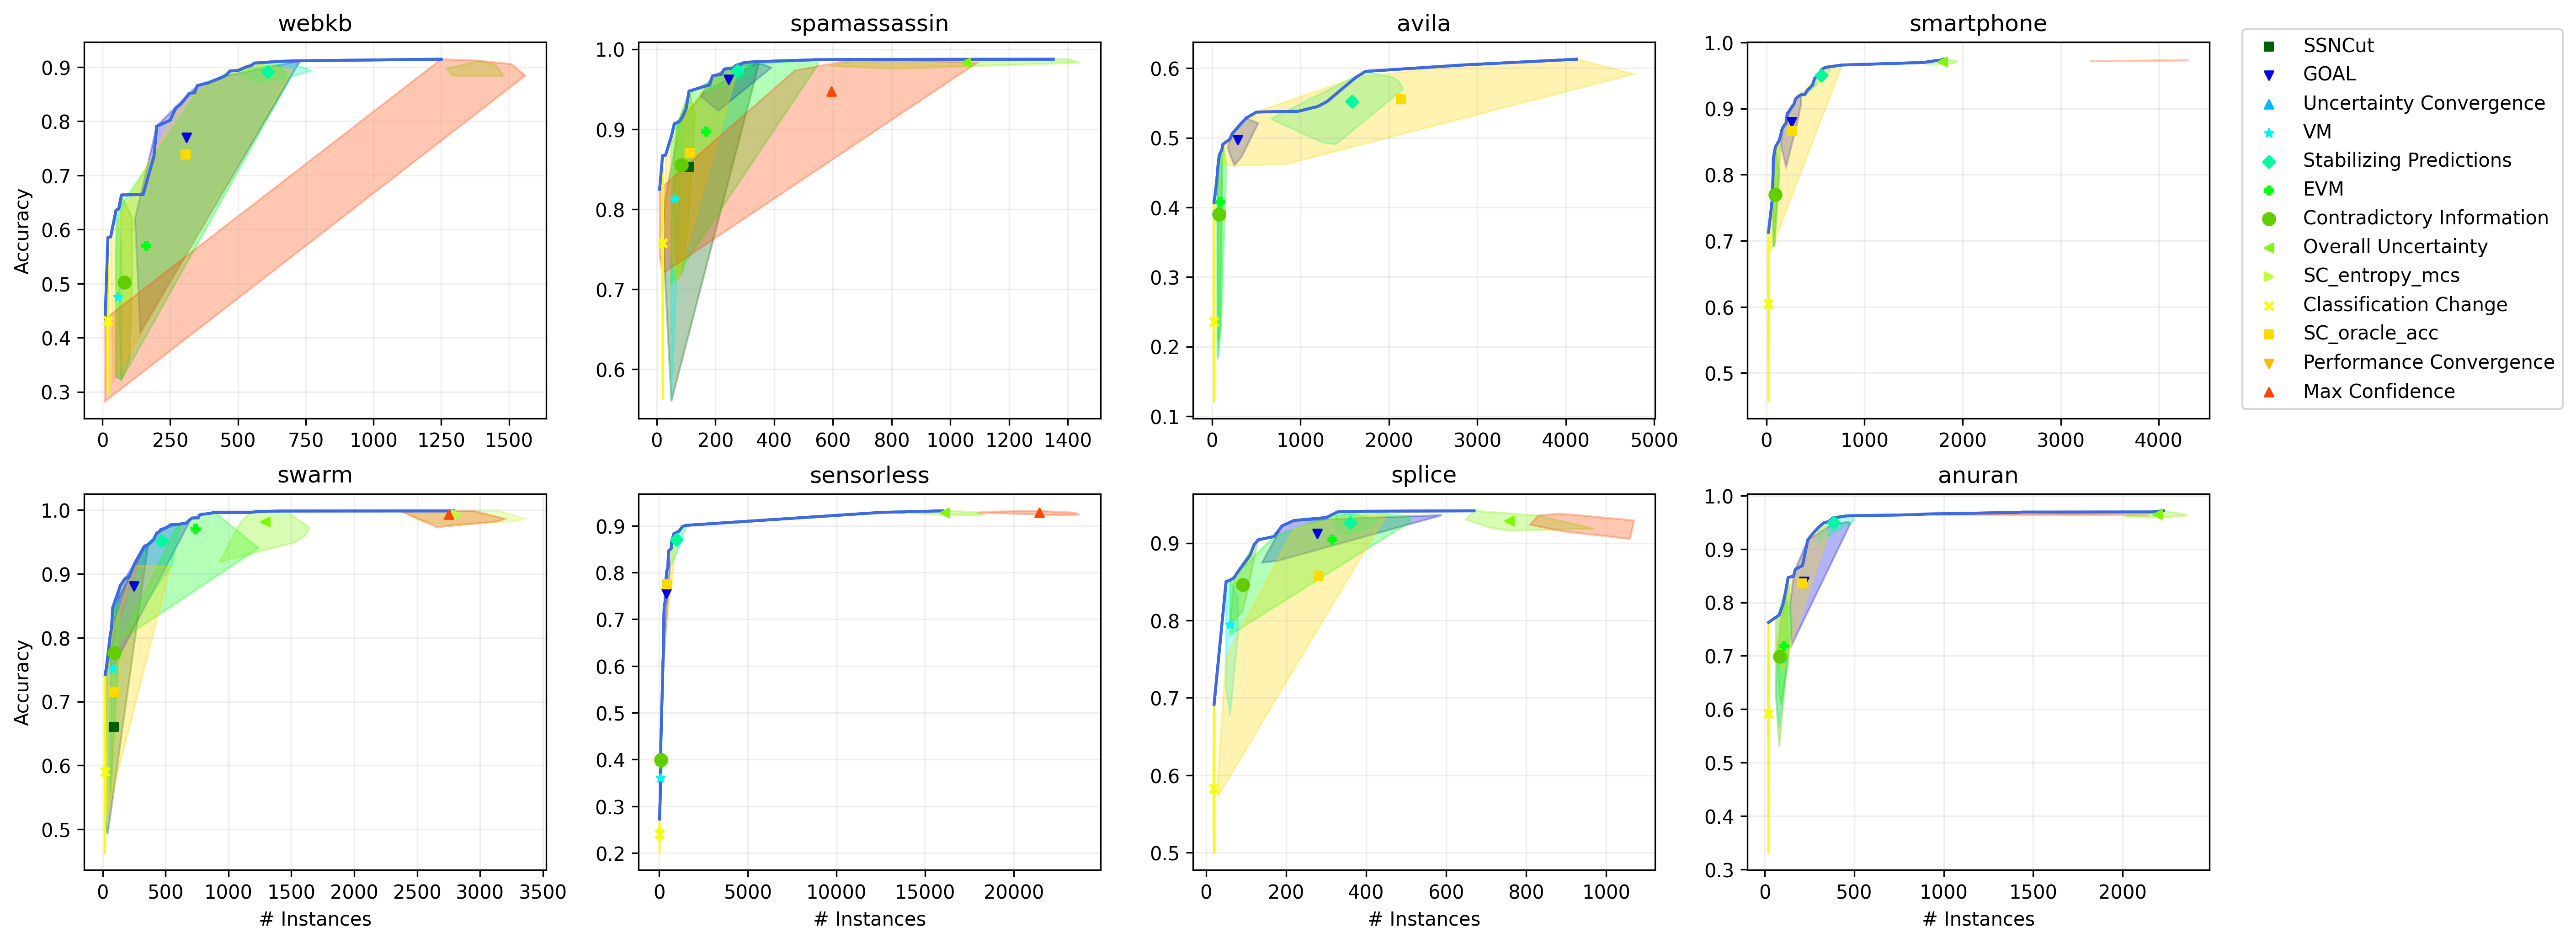

In [50]:
reload(libplot); from libplot import plot_paraeto_hull
plot_paraeto_hull(results_filter, rows=2, cols=4, figsize=(20,8))

In [22]:
results_filter['anuran']['Classification Change']

[(20.0, 0.5931072818232351, 0.5931072818232351, 0.1895733423243712),
 (20.0, 0.7073374096720401, 0.7073374096720401, 0.3868065383554037),
 (20.0, 0.6414674819344081, 0.6414674819344081, 0.2632712441963608),
 (20.0, 0.5483602001111729, 0.5483602001111729, 0.4287819554755946),
 (20.0, 0.7345747637576432, 0.7345747637576432, 0.1298165956412529),
 (20.0, 0.642023346303502, 0.642023346303502, 0.3606308645490039),
 (20.0, 0.3310172317954419, 0.3310172317954419, 0.2179048310331862),
 (20.0, 0.3721511951083935, 0.3721511951083935, 0.2985461555285641),
 (20.0, 0.5892162312395776, 0.5892162312395776, 0.40754111520069),
 (20.0, 0.5400222345747637, 0.5400222345747637, 0.4579705299038063),
 (20.0, 0.6022790439132851, 0.6022790439132851, 0.2752547467569403),
 (20.0, 0.6370205669816564, 0.6370205669816564, 0.4320263251309625),
 (20.0, 0.462479155086159, 0.462479155086159, 0.3843032170561192),
 (20.0, 0.6987215119510839, 0.6987215119510839, 0.2995607430780315),
 (20.0, 0.7087270705947749, 0.7087270705

Add more markers

In [8]:
split_boundaries = {
    'rcv1': None,
    'webkb': 500,
    'spamassassin': 400,
    'avila': 250,
    'smartphone': 1000,
    'swarm': 750,
    'sensorless': 3000,
    'splice': 350,
    'anuran': 500
}

In [9]:
from collections import defaultdict
from functools import partial
split1 = defaultdict(partial(defaultdict, list))
split2 = defaultdict(partial(defaultdict, list))

for dataset, methods in results_filter.items():
    for method, results in methods.items():
        for run in results:
            if run[0] is None:
                split1[dataset][method].append(run)
                split2[dataset][method].append(run)
                continue
            if run[0] < split_boundaries[dataset]:
                split1[dataset][method].append(run)
                split2[dataset][method].append([None,None,None,None])
            else:
                split1[dataset][method].append([None,None,None,None])
                split2[dataset][method].append(run)

## Split Pareto Plots

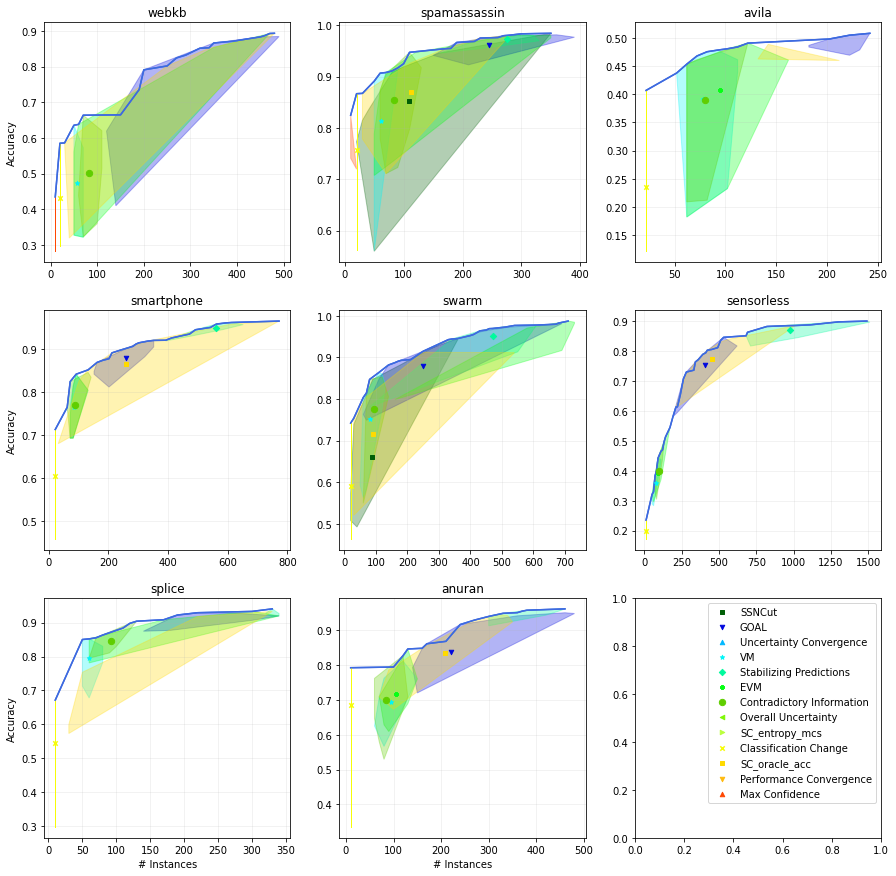

In [15]:
reload(libplot); from libplot import plot_paraeto_hull
plot_paraeto_hull(split1, hull_alpha=0.3)

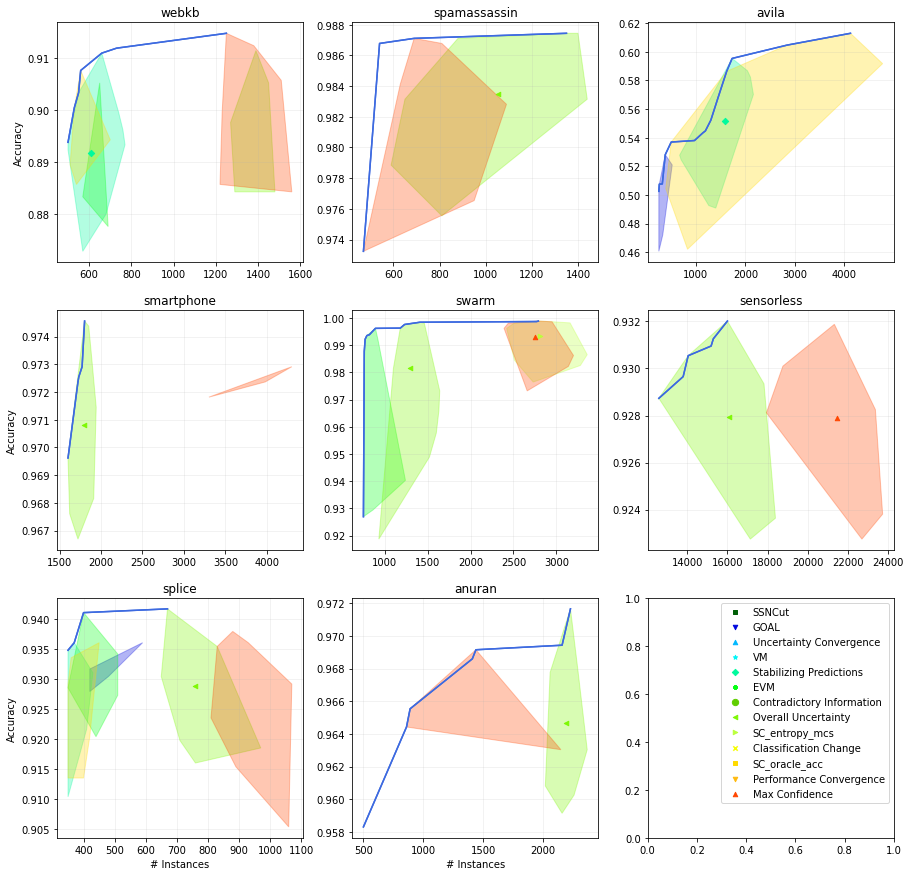

In [11]:
plot_paraeto_hull(split2)

In [6]:
from libstop import rank_stop_conds

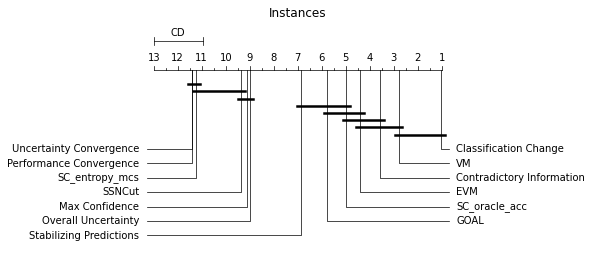

In [12]:
rank_stop_conds(results_filter, "instances");

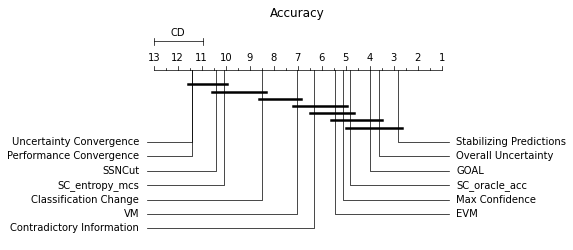

In [13]:
rank_stop_conds(results_filter, "accuracy_score");

## Failed To Stop

In [12]:
table = []
for dataset, methods in results_filter.items():
    table.append([])
    for method, results in methods.items():
        table[-1].append(f"{np.count_nonzero([result[0] for result in results])}/{len(results)}")

In [13]:
tabulate(table, tablefmt='html', showindex=results_filter.keys(), headers=results_filter['webkb'].keys())

,GOAL,SSNCut,SC_entropy_mcs,SC_oracle_acc,Stabilizing Predictions,Performance Convergence,Uncertainty Convergence,Max Confidence,EVM,VM,Contradictory Information,Classification Change,Overall Uncertainty
webkb,30/30,0/30,0/30,30/30,30/30,0/30,0/30,25/30,30/30,30/30,30/30,30/30,13/30
spamassassin,30/30,30/30,0/30,30/30,30/30,0/30,0/30,30/30,30/30,30/30,30/30,30/30,30/30
avila,30/30,0/30,0/30,30/30,30/30,0/30,0/30,0/30,30/30,30/30,30/30,30/30,0/30
smartphone,30/30,0/30,0/30,30/30,30/30,0/30,0/30,3/30,30/30,30/30,30/30,30/30,30/30
swarm,30/30,30/30,30/30,30/30,30/30,0/30,0/30,30/30,30/30,30/30,30/30,30/30,30/30
sensorless,30/30,0/30,0/30,30/30,30/30,0/30,0/30,30/30,30/30,30/30,30/30,30/30,30/30
splice,30/30,0/30,0/30,30/30,30/30,0/30,0/30,26/30,30/30,30/30,30/30,30/30,30/30
anuran,30/30,0/30,0/30,30/30,30/30,0/30,0/30,5/30,30/30,30/30,30/30,30/30,30/30


## Raw Results

In [93]:
table = []
for dataset, methods in results_filter.items():
    for method, results in methods.items():
        r = np.array(results)
        r = r[r[:,0]!=None]
        if len(r) == 0:
            table.append([dataset, method, *[None]*3])
            continue
        
        mean = np.mean(r, axis=0)
        # 2.5% percentile to 97.5%
        lower = np.percentile(r, 2.5, axis=0)
        upper = np.percentile(r, 97.5, axis=0)
        
        data = []
        for i in range(4):
            #data.append(f"{upper[i]:.2f}|{mean[i]:.2f}|{lower[i]:.2f}")
            data.append(upper[i])
            data.append(mean[i])
            data.append(lower[i])
    
        table.append(
            [dataset, method, *data]
        )

In [94]:
tabulate(
    table,
    tablefmt='html',
    headers=['Dataset', 'Method', 'Instances (Upper)', "Instances (Mean)", 'Instances (Lower)', 'Accuracy (Upper)', 'Accuracy (Mean)', 'Accuracy (Lower)', 'F1 (Upper)', 'F1 (Mean)', 'F1 (Lower)', 'ROC (Upper)', 'ROC (Mean)', 'ROC (Lower)'],
    floatfmt=('', '', *['g']*3, *['.2%']*6)
)

Dataset,Method,Instances (Upper),Instances (Mean),Instances (Lower),Accuracy (Upper),Accuracy (Mean),Accuracy (Lower),F1 (Upper),F1 (Mean),F1 (Lower),ROC (Upper),ROC (Mean),ROC (Lower)
webkb,GOAL,434.25,278,131.25,87.83%,74.46%,57.02%,87.83%,74.46%,57.02%,0.965526,0.913381,0.828042
webkb,SSNCut,,,,,,,,,,,,
webkb,SC_entropy_mcs,,,,,,,,,,,,
webkb,SC_oracle_acc,646,296,44.5,89.11%,71.23%,36.26%,89.11%,71.23%,36.26%,0.97251,0.886621,0.736938
webkb,Stabilizing Predictions,745.25,615,544.5,90.87%,89.00%,87.48%,90.87%,89.00%,87.48%,0.973699,0.965195,0.941108
webkb,Performance Convergence,,,,,,,,,,,,
webkb,Uncertainty Convergence,,,,,,,,,,,,
webkb,Max Confidence,1540,750,10,89.70%,66.25%,30.05%,89.70%,66.25%,30.05%,0.977654,0.717228,0.28901
webkb,EVM,616.5,200,50,88.78%,58.46%,34.19%,88.78%,58.46%,34.19%,0.956576,0.841857,0.750883
webkb,VM,70,56,50,58.47%,44.35%,32.46%,58.47%,44.35%,32.46%,0.844025,0.778234,0.71372


## Classification Change Checks

In [119]:
for name, methods in results_filter.items():
    print([run[0] for run in methods['Classification Change']])

[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
[12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0]
[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0]
[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
